# Community detection on reddit

In [2]:
import louvain
import igraph as ig
import networkx as nx
import community # python louvain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
% matplotlib inline

# Step 1: Load data

In [3]:
path = "/Users/anders1991/Desktop/reddit/edges.txt"
with open(path) as f:
    result = f.read()

In [4]:
with open("/Users/anders1991/Desktop/reddit/SubDict.pickle", 'rb') as f:
    subdict = pickle.load(f)

# Step 2: Inspect weight distribution

In [5]:
df = pd.read_csv(path, delim_whitespace=True, header=None)

In [6]:
df.head()

,0,1,2
0,1445,11588,1
1,1445,3396,2
2,1445,3397,3
3,1445,11590,4
4,1445,44359,2


In [7]:
freqs = pd.value_counts(df[2])
freqs.head()

1    149968554
2     34507054
3     14862794
4      8079152
5      4883826
Name: 2, dtype: int64

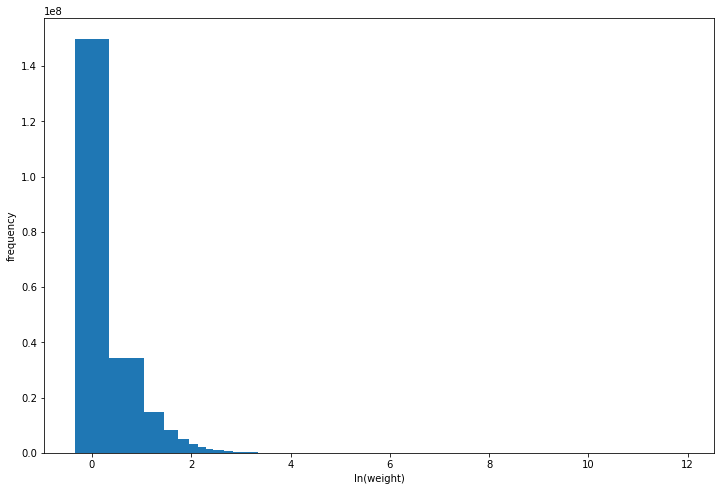

In [8]:
path = "/Users/anders1991/Desktop/reddit/plots/"

plt.figure(figsize=(12,8))
plt.bar(np.log(freqs.index), freqs, width=0.7)
plt.xlabel("ln(weight)")
plt.ylabel("frequency")
plt.savefig(path + "edgeweight_bar_annotated_unlogged.png", bbox_inches='tight')
plt.show()

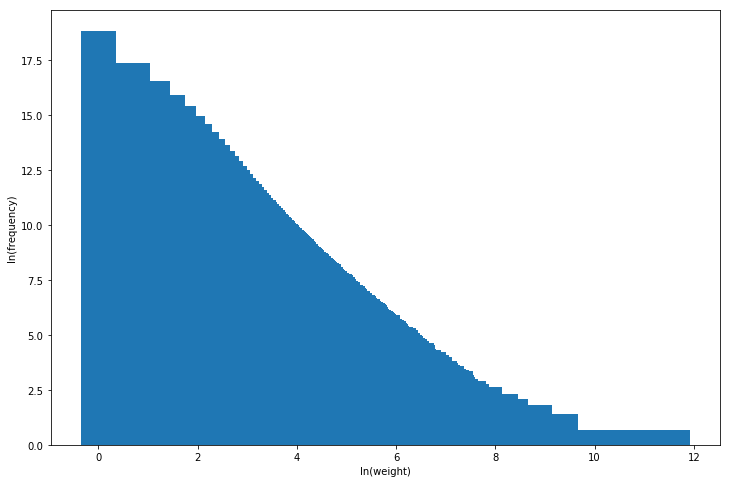

In [9]:
path = "/Users/anders1991/Desktop/reddit/plots/"

plt.figure(figsize=(12,8))
plt.bar(np.log(freqs.index), np.log(freqs), width=0.7)
plt.xlabel("ln(weight)")
plt.ylabel("ln(frequency)")
plt.savefig(path + "edgeweight_bar_annotated.png", bbox_inches='tight')
plt.show()

Mmm, power laws...

# Step 3: Save filtered edge lists to file

In [10]:
def filesaver(threshold):
    # threshold dataset by weight and convert to labels
    source = df.loc[np.log(df[2]) >= threshold][0].map(subdict)
    target = df.loc[np.log(df[2]) >= threshold][1].map(subdict)
    
    # merge to dataframe
    data = pd.merge(source.to_frame(), target.to_frame(), 
                    left_index=True, right_index=True)
    data.columns = ["Source", "Target"]
    
    # write thresholded dataset to file
    data.to_csv("edges_exp" + str(threshold) + ".csv", index=False)
    
    print("Threshold:", threshold)
    print("Nodes count:", len(set(data["Source"]).union(set(data["Target"]))))
    print("Edge count:", data.shape[0])

Save edgelist for all edges ($w > \exp(x)$)

In [14]:
filesaver(0)
filesaver(1)
filesaver(2)
filesaver(3)
filesaver(4)
filesaver(5)
filesaver(6)
filesaver(7)
filesaver(8)
filesaver(9)
filesaver(10)

('Threshold:', 0)
('Nodes count:', 70888)
('Edge count:', 225777872)
('Threshold:', 1)
('Nodes count:', 34256)
('Edge count:', 41302264)
('Threshold:', 2)
('Nodes count:', 19840)
('Edge count:', 8172832)
('Threshold:', 3)
('Nodes count:', 12095)
('Edge count:', 1719890)
('Threshold:', 4)
('Nodes count:', 7149)
('Edge count:', 526328)
('Threshold:', 5)
('Nodes count:', 3852)
('Edge count:', 176142)
('Threshold:', 6)
('Nodes count:', 1839)
('Edge count:', 56104)
('Threshold:', 7)
('Nodes count:', 778)
('Edge count:', 15658)
('Threshold:', 8)
('Nodes count:', 306)
('Edge count:', 3834)
('Threshold:', 9)
('Nodes count:', 98)
('Edge count:', 832)
('Threshold:', 10)
('Nodes count:', 28)
('Edge count:', 184)


# Step 4: Create graph

In [13]:
files = glob.glob("./edges_*.csv")
edgelists = [f.split('/')[-1] for f in files]
edgelists = sorted(edgelists, reverse=False)
edgelists

['edges_exp0.csv',
 'edges_exp1.csv',
 'edges_exp10.csv',
 'edges_exp2.csv',
 'edges_exp3.csv',
 'edges_exp4.csv',
 'edges_exp5.csv',
 'edges_exp6.csv',
 'edges_exp7.csv',
 'edges_exp8.csv',
 'edges_exp9.csv']

In [14]:
def loadGraph(name):
    G = nx.read_edgelist(name, delimiter=",")
    return G

# Step 5: Apply Louvain to graph with weights > threshold

In [15]:
def comms(name):
    G = loadGraph(name)
    partition = community.best_partition(G)
    return partition

In [75]:
commDict = {}

# only calc for thresholds >= exp2
for edges in edgelists[2:]:
    name = edges.split('_')[-1].split('.')[0]
    comm = comms(edges)
    commDict[name] = comm
    print("Completed:", edges)

('Completed:', 'edges_exp10.csv')
('Completed:', 'edges_exp2.csv')
('Completed:', 'edges_exp3.csv')
('Completed:', 'edges_exp4.csv')
('Completed:', 'edges_exp5.csv')
('Completed:', 'edges_exp6.csv')
('Completed:', 'edges_exp7.csv')
('Completed:', 'edges_exp8.csv')
('Completed:', 'edges_exp9.csv')


In [76]:
for name, groups in commDict.iteritems():
    print(name, len(set(groups.values())))

('exp9', 4)
('exp8', 5)
('exp3', 20)
('exp2', 44)
('exp7', 8)
('exp6', 13)
('exp5', 35)
('exp4', 39)
('exp10', 3)


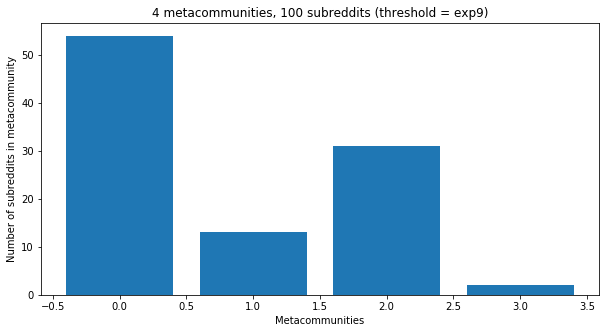

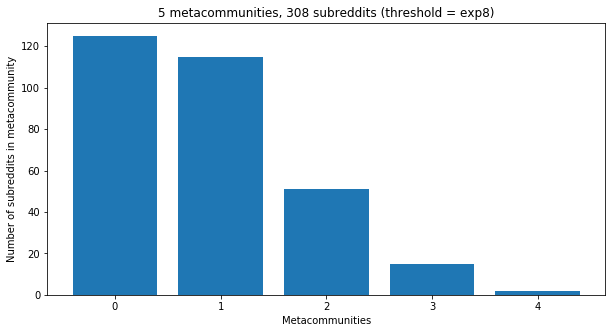

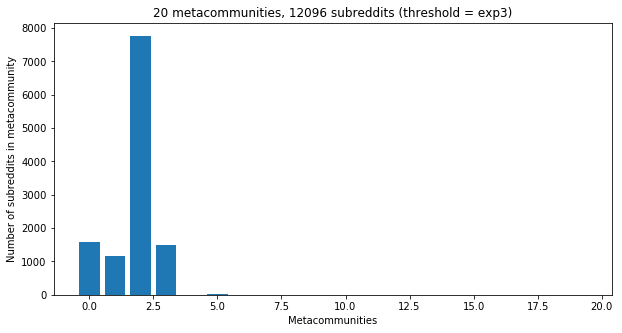

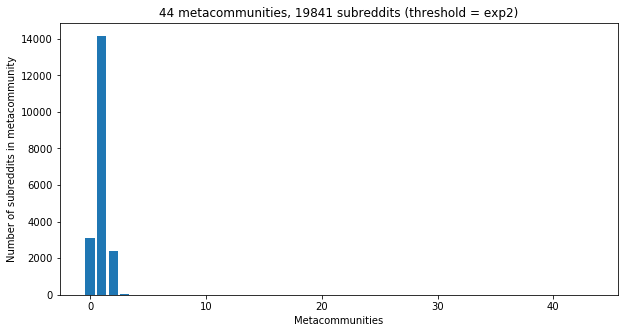

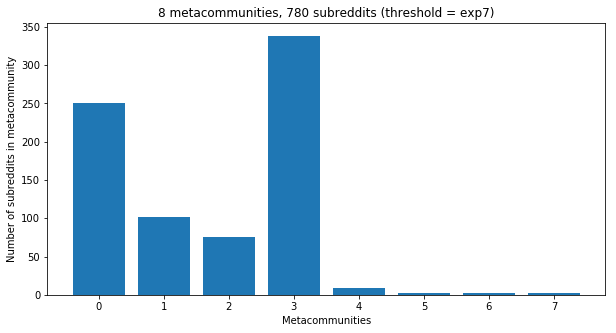

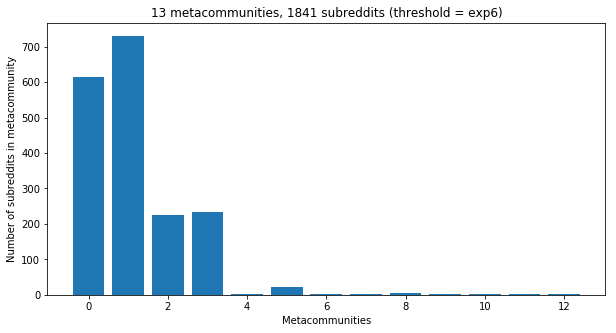

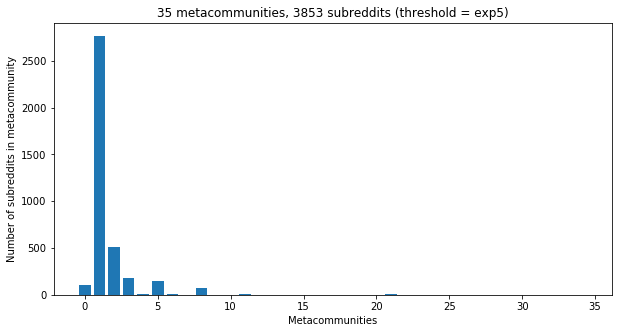

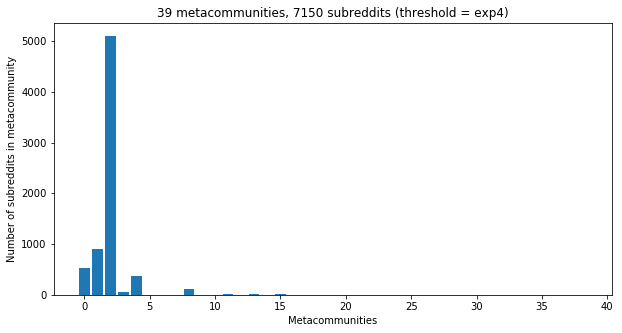

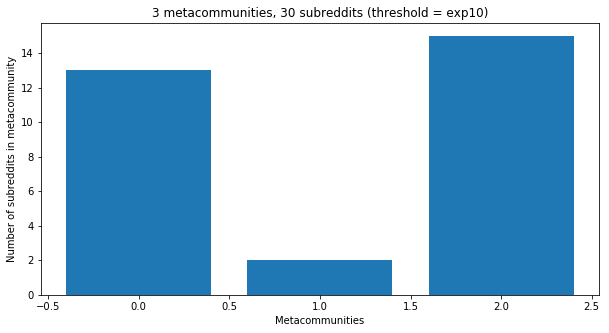

In [77]:
from collections import Counter

for name, parts in commDict.iteritems():
    subs = len(set(commDict[name].keys()))
    groups = Counter(parts.values()).values()
    communities = len(set(parts.values()))
    
    plt.figure(figsize=(10,5))
    plt.bar(range(communities), groups)
    plt.title(str(communities) + " metacommunities, " + str(subs) + " subreddits" " (threshold = " + name + ")")
    plt.xlabel("Metacommunities")
    plt.ylabel("Number of subreddits in metacommunity")
    path = "/Users/anders1991/Desktop/reddit/plots/"
    plt.savefig(path + name + ".png", bbox_inches='tight')
    plt.show()

# Step 6: Extract communities to file

In [78]:
for name in commDict.keys():
    groups = pd.DataFrame.from_dict(commDict[name], 'index')
    groups["Id"] = groups.index
    groups.columns = ["group", "Id"]
    groups = groups[["Id", "group"]]
    groups.to_csv("./" + name + "_groups.csv", index=False)

In [79]:
def commToDF(name):
    # get community modules
    communities = commDict[name]
    
    groups = pd.DataFrame.from_dict(communities, 'index')
    groups["subreddit"] = groups.index
    groups.columns = ["group", "subreddit"]
    groups = groups[["subreddit", "group"]]
    groups.reset_index(inplace=True, drop=True)
    return groups

def commExport(name):
    groups = commToDF(name)
    groups.to_csv("./groups_" + name + ".csv", index=False)

In [54]:
for name in commDict.keys():
    commExport(name)

----

# Calculate modularity

In [80]:
# find total degree of nodes in the group
def k_c(group):
    k_c = 0
    for phil in group:
        k_c += G.degree()[phil]
    return k_c

# find number of edges where both nodes are in group
def L_c(group):
    L_c = 0
    for edge in G.edges():
        nodes = set(edge)
        if group.issuperset(nodes):
            L_c += 1
    return L_c

# compute modularity using equation 9.12
def M(graph, groups):
    modularity = 0
    L = float(len(graph.edges()))
    for group in groups:
        Lc = L_c(group)
        kc = k_c(group)
        Mc = Lc/L - (kc/(2.0*L))**2.0
        modularity += Mc
    return modularity

In [105]:
modularities = dict()

for name in commDict.keys():
    louvain = [set() for i in range(max(commDict[name].values())+1)]
    for idx, group in commDict[name].iteritems():
        if idx != "Source" and idx != "Target":
            louvain[group].add(idx)
    
    G = nx.read_edgelist("edges_"+name+".csv", delimiter=",")
    G.remove_nodes_from(["Source", "Target"])
    mod = M(G, louvain)
    
    modularities[name] = mod
    print "Modularity (" + str(name) + "):", mod

Modularity (exp9): 0.225360576923
Modularity (exp8): 0.210930996827
Modularity (exp3): 0.18642456341
Modularity (exp2): 0.133217648569
Modularity (exp7): 0.24777041077
Modularity (exp6): 0.253041503721
Modularity (exp5): 0.240854865556
Modularity (exp4): 0.220275067971
Modularity (exp10): 0.195120510397


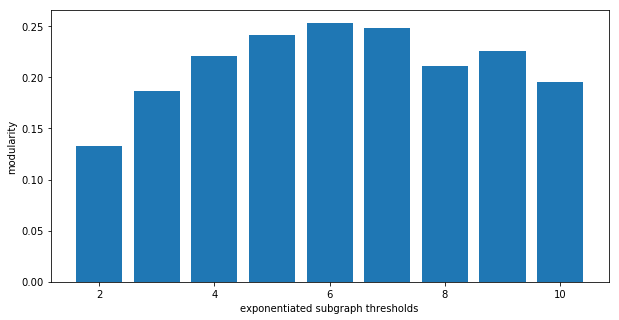

In [117]:
xvals = [i for i in range(2,11)]
yvals = [modularities["exp"+str(i)] for i in range(2,11)] 

plt.figure(figsize=(10,5))
plt.bar(xvals, yvals)
plt.xlabel("exponentiated subgraph thresholds")
plt.ylabel("modularity")
path = "/Users/anders1991/Desktop/reddit/plots/"
plt.savefig(path + "modularity_bar.png", bbox_inches='tight')
plt.show()

----

# Create joint metadata csv

In [69]:
metadata = pd.read_csv("/Users/anders1991/Desktop/reddit/content/000000000000.csv")
metadata = metadata.append(pd.read_csv("/Users/anders1991/Desktop/reddit/content/000000000001.csv"))
metadata = metadata.append(pd.read_csv("/Users/anders1991/Desktop/reddit/content/000000000002.csv"))
metadata = metadata.reset_index(drop=True)
metadata["ln_score"] = np.log(metadata["score"])
metadata.loc[metadata["ln_score"] < 0, "ln_score"] = 0 # fix ln(0) = -inf
metadata.head()

/Users/anders1991/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


,subreddit,title,domain,num_comments,score,over_18,is_self,ln_score
0,gaming,Gorging on Insect Jelly [RimWorld] - Credit So...,youtube.com,0,10,False,False,2.302585
1,ImagesOfGeorgia,Opening Night at GSU Stadium!,imgur.com,1,1,False,False,0.000000
2,type2diabetes,Associations of fats and carbohydrate intake w...,thelancet.com,0,4,False,False,1.386294
3,AskReddit,"You just got paid, so what's the non-necessity...",self.AskReddit,7,1,False,True,0.000000
4,freefolk,Leaked photo from season 7 premiere,i.redd.it,2,9,False,False,2.197225


In [122]:
groups = commToDF("exp3")
groups.head()

,subreddit,group
0,danganronpa,0
1,raining,1
2,OOTP,2
3,yoyhammer,1
4,exmormon,3


In [123]:
data = pd.merge(metadata, groups, how='inner', on=['subreddit', 'subreddit'])
data.head()

,subreddit,title,domain,num_comments,score,over_18,is_self,ln_score,group
0,gaming,Gorging on Insect Jelly [RimWorld] - Credit So...,youtube.com,0,10,False,False,2.302585,1
1,gaming,When you realize...,i.imgur.com,0,0,False,False,0.000000,1
2,gaming,Tracer Overwatch cosplay by @happyacorncosplay,i.redd.it,7,8,False,False,2.079442,1
3,gaming,Name this game please?!,self.gaming,3,1,False,True,0.000000,1
4,gaming,Call of Duty®: Infinite Warfare_20170816064211,youtube.com,0,1,False,False,0.000000,1


In [139]:
G = nx.read_edgelist("edges_exp10.csv", delimiter=",")
G.remove_nodes_from(["Source", "Target"])

groups_degs = pd.DataFrame.from_dict(G.degree(), 'index')
groups_degs["subreddit"] = groups_degs.index
groups_degs.columns = ['degree', 'subreddit']
groups_degs["ln_degree"] = np.log(groups_degs["degree"])
groups_degs.reset_index(drop=True, inplace=True)
groups_degs.head()

,degree,subreddit,ln_degree
0,10,mildlyinteresting,2.302585
1,12,videos,2.484907
2,13,todayilearned,2.564949
3,1,interestingasfuck,0.000000
4,1,Music,0.000000


In [141]:
data = pd.merge(data, groups_degs, how='inner', on=['subreddit', 'subreddit'])
data.head()

,subreddit,title,domain,num_comments,score,over_18,is_self,ln_score,group,degree,ln_degree
0,gaming,Gorging on Insect Jelly [RimWorld] - Credit So...,youtube.com,0,10,False,False,2.302585,1,12,2.484907
1,gaming,When you realize...,i.imgur.com,0,0,False,False,0.000000,1,12,2.484907
2,gaming,Tracer Overwatch cosplay by @happyacorncosplay,i.redd.it,7,8,False,False,2.079442,1,12,2.484907
3,gaming,Name this game please?!,self.gaming,3,1,False,True,0.000000,1,12,2.484907
4,gaming,Call of Duty®: Infinite Warfare_20170816064211,youtube.com,0,1,False,False,0.000000,1,12,2.484907


In [142]:
data.to_csv("/Users/anders1991/Desktop/reddit/metadata.csv", index=False)

----

In [143]:
nodedata = data[["subreddit", "group", "over_18", "degree", "ln_degree", "is_self"]]
nodedata.head()

,subreddit,group,over_18,degree,ln_degree,is_self
0,gaming,1,False,12,2.484907,False
1,gaming,1,False,12,2.484907,False
2,gaming,1,False,12,2.484907,False
3,gaming,1,False,12,2.484907,True
4,gaming,1,False,12,2.484907,False


In [144]:
nodedata_a = nodedata.groupby(["subreddit"])[["group", "degree", "ln_degree"]].first()
nodedata_a.head()

,group,degree,ln_degree
subreddit,,,
AdviceAnimals,1,1,0.000000
AskReddit,1,27,3.295837
BlackPeopleTwitter,1,1,0.000000
IAmA,1,1,0.000000
Jokes,2,1,0.000000


In [145]:
nodedata_b = nodedata.groupby(["subreddit"])[["over_18", "is_self"]].mean()
nodedata_b.head()

,over_18,is_self
subreddit,,
AdviceAnimals,0.001728,0.000000
AskReddit,0.027769,1.000000
BlackPeopleTwitter,0.011442,0.002034
IAmA,0.007563,1.000000
Jokes,0.044767,1.000000


In [146]:
nodedata_c = nodedata.groupby(["subreddit"])["subreddit"].count()
nodedata_c = nodedata_c.to_frame()
nodedata_c.columns = ['num_posts']
nodedata_c["ln_num_posts"] = np.log(nodedata_c["num_posts"])
nodedata_c.head()

,num_posts,ln_num_posts
subreddit,,
AdviceAnimals,6944,8.845633
AskReddit,215854,12.282358
BlackPeopleTwitter,3933,8.277158
IAmA,1719,7.449498
Jokes,18697,9.836118


In [ ]:
nodedata = pd.merge(nodedata_a, nodedata_b, how='inner', left_index=True, right_index=True)
nodedata = pd.merge(nodedata, nodedata_c, how='inner', left_index=True, right_index=True)
nodedata.head()

In [148]:
nodedata.to_csv("/Users/anders1991/Desktop/reddit/nodes_data.csv")